# Binary and barrier options

In this notebook we want to study the problem of pricing some exotic derivatives by solving their associated PDE.

I will use the same framework, based on the implicit discretization, presented in the Black-Scholes PDE notebook **2.1**.
The results are then compared with the values obtained from other numerical methods.

## Contents
   - [Digital/Binary options](#sec1)
      - [Numerical solution](#sec1.1)
   - [Barrier options](#sec2)
      - [Numerical solution](#sec2.1)

In [1]:
from functions.BS_pricer import BS_pricer
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

In [2]:
# Option variables
S0=100.0              # spot stock price
K=100.0               # strike
T=1.0                 # maturity 
r=0.1                 # risk free rate 
sig=0.2               # diffusion coefficient or volatility
X0 = np.log(S0)       # logprice
B = 120               # Barrier

<a id='sec1'></a>
## Binary/digital options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Binary_option)

Let us consider the case of a **cash or nothing CALL** binary option:

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ \mathbb{1}_{\{S_T > K\}} \, \big| \, S_t=s \bigr].
\end{equation}

where, as usual, $\mathbb{Q}$ is the risk neutral measure.

<a id='sec1.1'></a>
## Numerical solution

#### Closed formula

In [108]:
# Closed formula
d2 = (np.log(S0/K) + (r - sig**2 / 2) * T) / (sig * np.sqrt(T))
N2 = ss.norm.cdf(d2)
closed_digital = np.exp(-r*T) * N2
print("The price of the ATM digital call option by closed formula is: ", closed_digital)

The price of the ATM digital call option by closed formula is:  0.5930501164033175


#### Monte Carlo

In [109]:
# Monte Carlo
np.random.seed(seed=42)
N_simulation = 20000000
W = (r - sig**2/2)*T  + ss.norm.rvs(loc=0, scale=sig, size=N_simulation)
S_T = S0 * np.exp(W)

MC_digital = np.exp(-r*T) * scp.mean( S_T > K )
print("The price of the ATM digital call option by Monte Carlo is: ", MC_digital)

The price of the ATM digital call option by Monte Carlo is:  0.593071342432063


#### PDE method:

In [11]:
# PDE
Nspace = 6000   # M space steps
Ntime = 5000    # N time steps   
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
Payoff = np.where(np.exp(x)>K, 1, 0)          # Binary payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = 1                        # boundary condition
V[0,:] = 0                         # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print("The price of the ATM digital call option by PDE is: ", oPrice)

The price of the ATM digital call option by PDE is:  0.5930454651650973


#### Plots

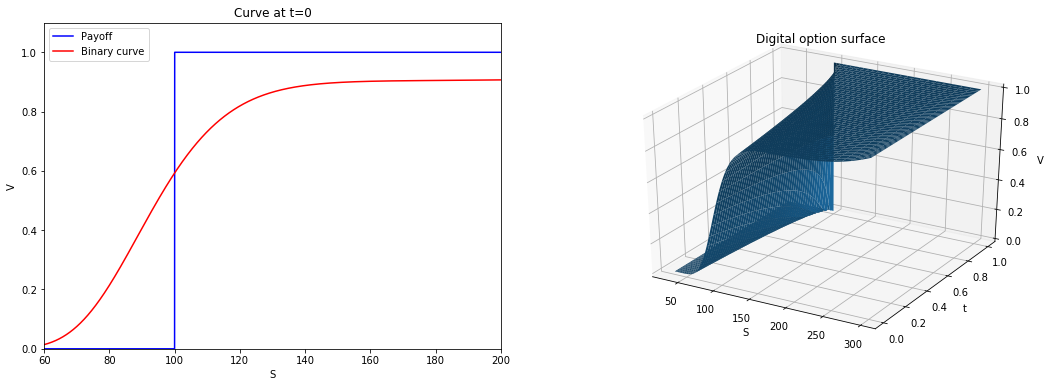

In [12]:
S = np.exp(x)
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="Binary curve")
ax1.set_xlim(60,200); ax1.set_ylim(0,1.1)
ax1.set_xlabel("S"); ax1.set_ylabel("V"); ax1.legend(loc='upper left')
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Digital option surface"); ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
plt.show()

<a id='sec2'></a>
## Barrier options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Barrier_option)

Let us consider the case of an **Up and Out CALL** European option:

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (S_T - K)^+ \mathbb{1}_{\{M_T < B\}} \, \big| \, S_t=s \bigr].
\end{equation}

where I introduced the running max:

$$ M_T = \max_{0\leq t \leq T} S_t. $$

The parameter $B$ is the barrier.     
We have to assume that $B > K$, otherwise the payoff would be always zero. 


<a id='sec2.1'></a>
## Numerical solution

#### Closed formula:

In [138]:
d1 = lambda t,s: 1/(sig*np.sqrt(t)) * ( np.log(s) + (r+sig**2/2)*t ) 
d2 = lambda t,s: 1/(sig*np.sqrt(t)) * ( np.log(s) + (r-sig**2/2)*t ) 

In [144]:
closed_barrier = S0 * ( ss.norm.cdf( d1(T, S0/K) ) - ss.norm.cdf( d1(T, S0/B) ) ) \
      - np.exp(-r*T) * K * ( ss.norm.cdf( d2(T, S0/K) ) - ss.norm.cdf( d2(T, S0/B) ) ) \
      - B * (S0/B)**(-2*r/sig**2) * ( ss.norm.cdf( d1(T, B**2/(S0*K) ) ) - ss.norm.cdf( d1(T, B/S0) ) ) \
      + np.exp(-r*T) * K * (S0/B)**(-2*r/sig**2 + 1) * \
      ( ss.norm.cdf( d2(T, B**2/(S0*K) ) ) - ss.norm.cdf( d2(T, B/S0) ) )

In [145]:
print("The price of the Up and Out call option by closed formula is: ", closed_barrier)

The price of the Up and Out call option by closed formula is:  1.1789018151004562


#### Monte Carlo:

In [5]:
%%time
np.random.seed(seed=42)
N = 10000
paths = 50000
dt = T/(N-1)          # time interval

#path generation
X_0 = np.zeros((paths,1))
increments = ss.norm.rvs(loc=(r-sig**2/2)*dt, scale=np.sqrt(dt)*sig, size=(paths,N-1))
X = np.concatenate((X_0,increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)      # maximum of each path

# discounted expected payoff
MC_barrier = np.exp(-r * T) * (np.maximum( S[:,-1] - K, 0 ) @ np.where(M<B,1,0) )/ paths

CPU times: user 30.8 s, sys: 9.3 s, total: 40.1 s
Wall time: 53.5 s


In [6]:
print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier)

The price of the Up and Out call option by Monte Carlo is:  1.2023400529852908


It is well known that Monte Carlo methods are slow.

When working with path dependent options, such as Barrier options, it is necessary to generate the entire paths. This is SUPER slow!! 

With C and Cython it is possible to improve the performance.

There are several methods to improve the algorithm:
- using antithetic variables [wiki](https://en.wikipedia.org/wiki/Antithetic_variates) to reduce the total variance.
- using the Brownian bridge in order to reduce the error introduced by the time step discretization. Between two time points there is a non-zero probability that the process hits the barrier and returns back. We are missing this event, and this creates a positive bias in the final price (indeed our price is a bit higher).

Well we are happy with our price, which is very close to the correct (closed formula) price.

#### PDE method:

In [7]:
# PDE
Nspace = 14000   # M space steps
Ntime = 10000    # N time steps   
S_max = B        # The max of S corresponds to the Barrier           
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
Payoff = np.maximum(np.exp(x)-K,0)          # Call payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = 0                        # boundary condition
V[0,:] = 0                         # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print("The price of the Up and Out option by PDE is: ", oPrice)

The price of the Up and Out option by PDE is:  1.1790256853164922


#### Plots

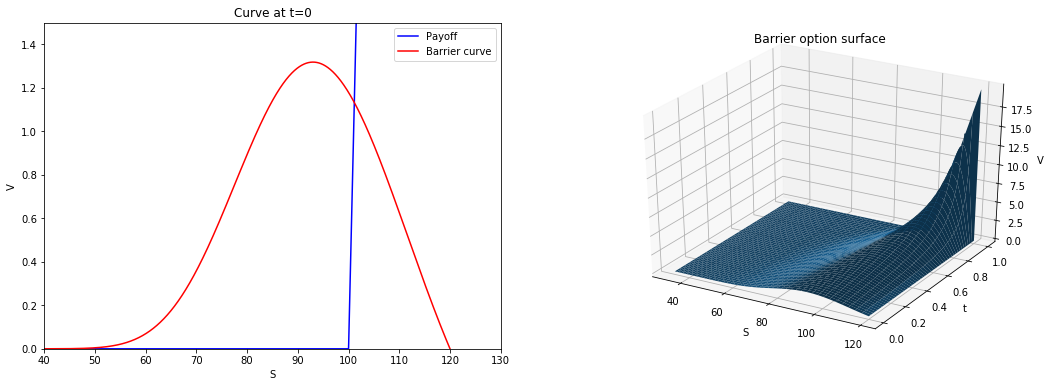

In [10]:
S = np.exp(x)
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="Barrier curve")
ax1.set_xlim(40,130); ax1.set_ylim(0,1.5)
ax1.set_xlabel("S"); ax1.set_ylabel("V"); ax1.legend(loc='upper right')
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Barrier option surface"); ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
plt.show()

### References

[1]  Daniel Sevcovic, Beata Stehlikova, Karol Mikula (2011). Analytical and numerical methods for pricing financial derivatives. Nova Science Pub Inc; UK. 

[2] Wilmott Paul (1994). Option pricing: Mathematical models and computation. Oxford Financial Press